In this notework, we are going to preprocess and analyze the dataset.

Apart from the [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/) dataset, several external datasets are used, including Oscar Award dataset and IMDb dataset.

In [67]:
import json

import numpy as np

import pandas as pd
import seaborn as sns

from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

# 1. Preprocessing and description of CMU Movie Summary Corpus

This dataset contains several separate files:
1. MovieSummaries/character.metadata.tsv
2. MovieSummaries/movie.metadata.tsv
3. MovieSummaries/name.clusters.txt
4. MovieSummaries/plot_summaries.txt
5. MovieSummaries/tvtropes.clusters.txt

Some constants are defined here, espeically the header of the CSV files.

In [2]:
# headers of the CSV files in CMU Movie Summary Corpus

movie_metadata_header = [
    'Wikipedia movie ID',
    'Freebase movie ID',
    'Movie name',
    'Movie release date',
    'Movie box office revenue',
    'Movie runtime',
    'Movie languages',
    'Movie countries',
    'Movie genres'
]

character_metadata_header = [
    'Wikipedia movie ID',
    'Freebase movie ID',
    'Movie release date',
    'Character Name',
    'Actor DOB',
    'Actor gender',
    'Actor height',
    'Actor ethnicity',
    'Actor Name',
    'Actor age at movie release',
    'Freebase character map',
    'Freebase character ID',
    'Freebase actor ID'
]

## 1.1 Preprocessing the description of character metadata

In [3]:
# read the character metadata

character_metadata = pd.read_csv(
    'MovieSummaries/character.metadata.tsv',
    delimiter='\t',
    names=character_metadata_header
)

print('There are {} entries in the character metadata.'.format(len(character_metadata)))
print('Each entry contains:')
for idx, column in enumerate(character_metadata.columns):
    print('{:>5}.'.format(idx + 1), column)

There are 450669 entries in the character metadata.
Each entry contains:
    1. Wikipedia movie ID
    2. Freebase movie ID
    3. Movie release date
    4. Character Name
    5. Actor DOB
    6. Actor gender
    7. Actor height
    8. Actor ethnicity
    9. Actor Name
   10. Actor age at movie release
   11. Freebase character map
   12. Freebase character ID
   13. Freebase actor ID


### How is the distribution of the DOB of Actors?

count                  344501
unique                  29219
top       1908-05-30 00:00:00
freq                      791
Name: Actor DOB, dtype: object


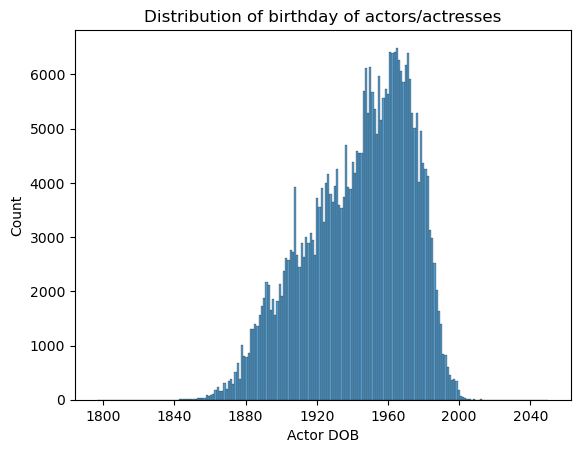

In [16]:
actor_dob = pd.to_datetime(character_metadata['Actor DOB'], infer_datetime_format=True, errors='coerce').dropna()

print(actor_dob.describe())

sns.histplot(actor_dob)
plt.title('Distribution of birthday of actors/actresses')
plt.show()

### How is the distribution of ethnicities of actors?

The ethnicity information in the Movie Summaries Corpus uses FreeBase ID. However, the FreeBase is no longer available and the Google Developer API for FreeBase ID search is also deprecated. Hence, we have to download a dataset containing mappings from FreeBase ID to WikiData ID.

In [17]:
# read and process the fb2w.nt dataset, creating a dictionary mapping from
# FreeBase ID to WikiData URL

mapping_freebase = {}

with open('fb2w.nt', 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break

        if line.startswith('<'):
            links = line.split('\t')
            freebase_id = '/' + links[0][1:-1].split('/')[-1].replace('.', '/')
            wikidata_url = links[2][1:-4].replace('entity', 'wiki')

            mapping_freebase[freebase_id] = wikidata_url


In [23]:
# retrieve the FreeBase ID of ethnicities and thus the WikiData URL of them

ethnicities_freebase = character_metadata['Actor ethnicity'].unique()

ethnicities_wikidata = []
ethnicities_freebase_found = []

for i in ethnicities_freebase:
    if i in mapping_freebase.keys():
        ethnicities_wikidata.append(mapping_freebase[i])
        ethnicities_freebase_found.append(i)


print('Among all the {} entries in the Movie Summareis Corpus, {} entries contain ethnicity information.'.format(
    len(character_metadata['Actor ethnicity']),
    character_metadata['Actor ethnicity'].count()
))

print('There are {} unique ethnicities FreeBase IDs in the Movie Summaries Corpus.'.format(len(ethnicities_freebase)))
print('There are {} mappings found from FreeBase ID to WikiData URL.'.format(len(ethnicities_wikidata)))

print('Finally, there are {} entries with available ethnicity information.'.format(
    character_metadata['Actor ethnicity'].isin(ethnicities_freebase_found).sum()
))

Among all the 450669 entries in the Movie Summareis Corpus, 106058 entries contain ethnicity information.
There are 480 unique ethnicities FreeBase IDs in the Movie Summaries Corpus.
There are 354 mappings found from FreeBase ID to WikiData URL.
Finally, there are 93066 entries with available ethnicity information.


In [25]:
# search the WikiData

import urllib.request
import re

mapping_dict = {}

for i in tqdm(ethnicities_freebase):
    if i in mapping_freebase.keys():
        url = mapping_freebase[i]
        response = urllib.request.urlopen(url)
        html_content = response.read().decode()

        m = re.search("<meta property=\"og:title\" content=\"(.*?)\"/>", html_content)
        mapping_dict[i] = m.group(1)


100%|██████████| 480/480 [03:44<00:00,  2.13it/s]


In [26]:
ethnicities_stats = character_metadata['Actor ethnicity'].map(mapping_dict).dropna().reset_index(drop=True)

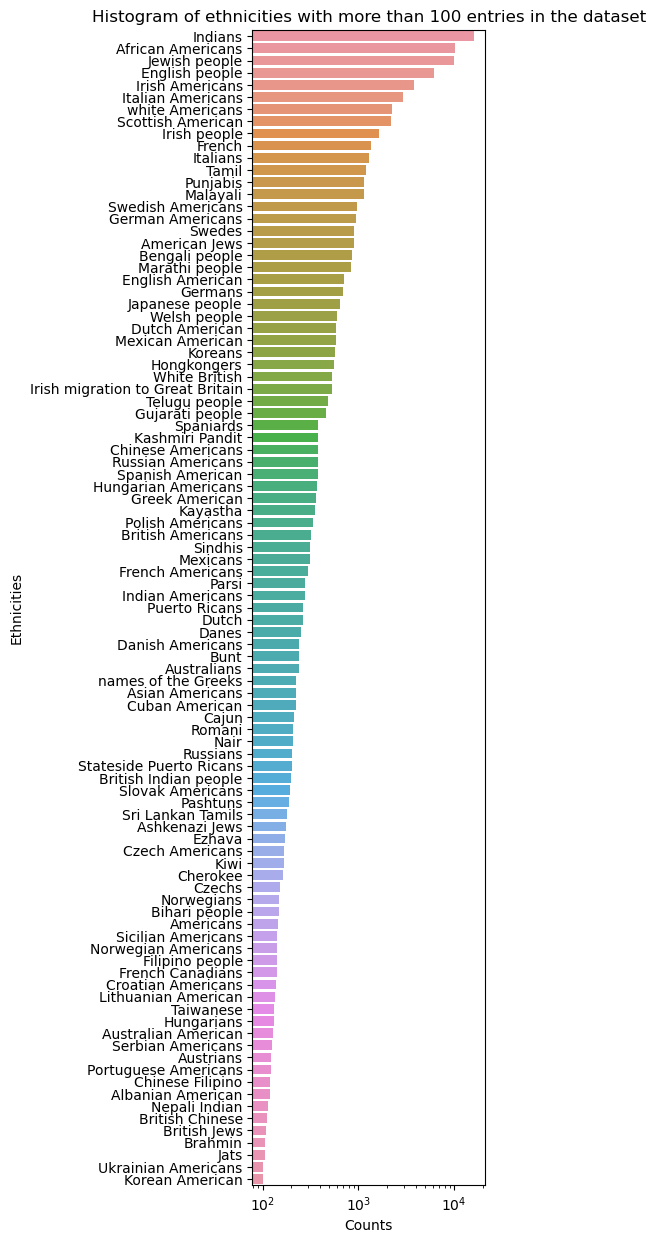

In [54]:
plt.figure(figsize=(3, 15))
ethnicities_counts = ethnicities_stats.value_counts()
ethnicities_counts_filtered = ethnicities_counts[ethnicities_counts > 100]
g = sns.barplot(y=ethnicities_counts_filtered.index, x=ethnicities_counts_filtered, orient='h')
g.set_xscale('log')
g.set_title('Histogram of ethnicities with more than 100 entries in the dataset')
g.set_xlabel('Counts')
g.set_ylabel('Ethnicities')
plt.show()

## 1.2 Preprocessing and description of move metadata

In [55]:
# read the movie metadata

movie_metadata = pd.read_csv(
    'MovieSummaries/movie.metadata.tsv',
    delimiter='\t',
    names=movie_metadata_header
)

In [57]:
movie_metadata

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


### How is the distribution of movie release date?

Among 81741 entries, there are 74838 entries with movie release date.


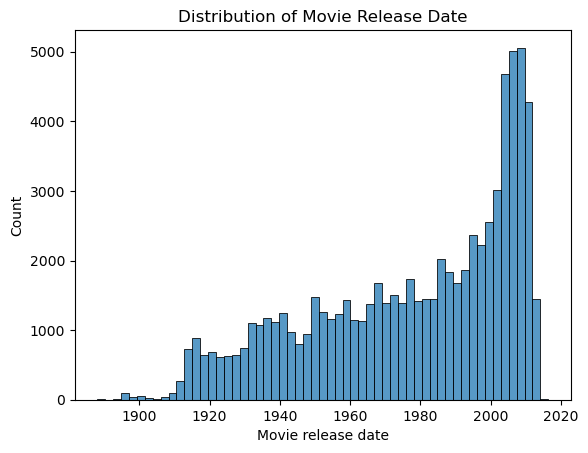

In [61]:
movie_release_date = pd.to_datetime(movie_metadata['Movie release date'], errors='coerce', yearfirst=True)

print('Among {} entries, there are {} entries with movie release date.'.format(
    len(movie_release_date),
    movie_release_date.count()
))

sns.histplot(movie_release_date.dropna())
plt.title('Distribution of Movie Release Date')
plt.show()

### How is the distribution of movie languages?

In [72]:
movie_countries = movie_metadata['Movie countries']

print('Among {} entries, there are {} entries with movie release date.'.format(
    len(movie_countries),
    movie_countries.count()
))

# json.loads(movie_metadata['Movie countries'][0]).values()

Among 81741 entries, there are 81741 entries with movie release date.


In [80]:
movie_countries_counts = {}

for i in movie_countries.dropna():
    countries = json.loads(i).values()
    for j in countries:
        if j in movie_countries_counts.keys():
            movie_countries_counts[j] += 1
        else:
            movie_countries_counts[j] = 1

movie_countries_counts = pd.Series(movie_countries_counts).sort_values(ascending=False)

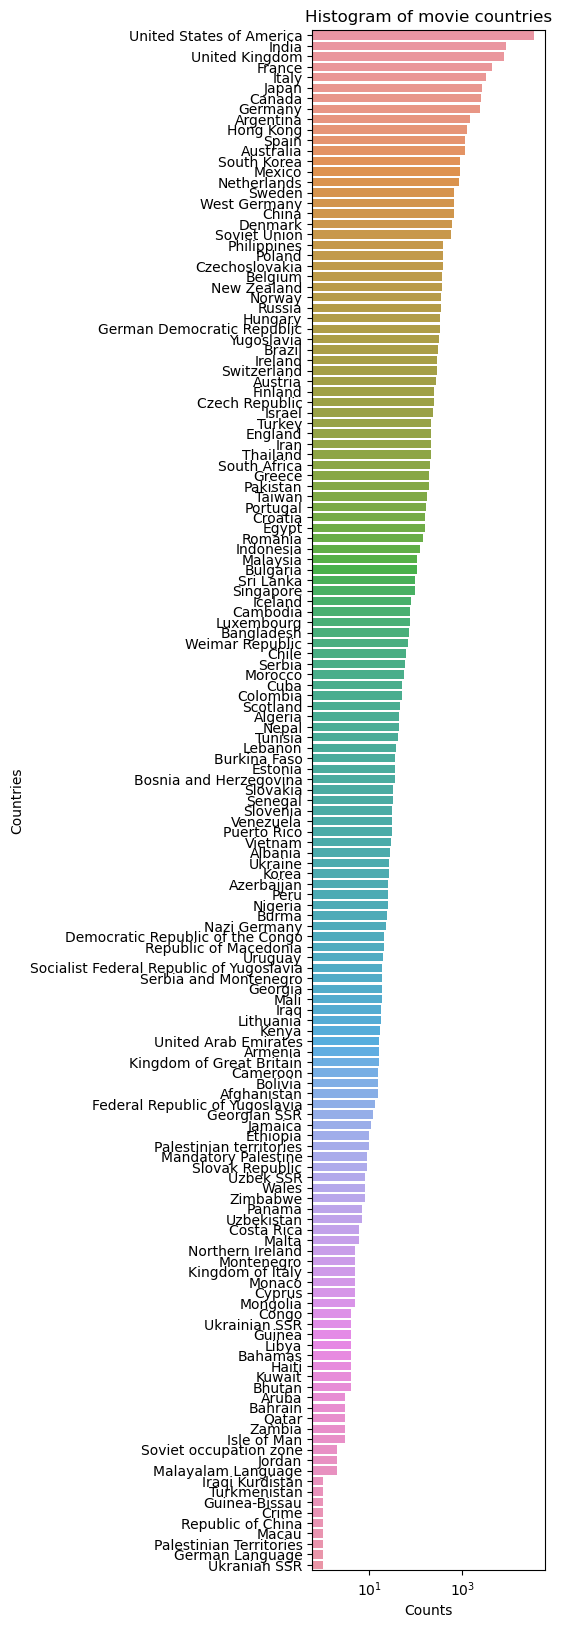

In [85]:
plt.figure(figsize=(3, 20))
g = sns.barplot(y=movie_countries_counts.index, x=movie_countries_counts, orient='h')
g.set_xscale('log')
g.set_title('Histogram of movie countries')
g.set_xlabel('Counts')
g.set_ylabel('Countries')
plt.show()

### How is the distribution of movie genres?

In [86]:
movie_genres = movie_metadata['Movie genres']

print('Among {} entries, there are {} entries with movie genres.'.format(
    len(movie_genres),
    movie_genres.count()
))

Among 81741 entries, there are 81741 entries with movie genres.


In [91]:
movie_genres_counts = {}

for i in movie_genres.dropna():
    genres = json.loads(i).values()
    for j in genres:
        if j in movie_genres_counts.keys():
            movie_genres_counts[j] += 1
        else:
            movie_genres_counts[j] = 1

movie_genres_counts = pd.Series(movie_genres_counts).sort_values(ascending=False)

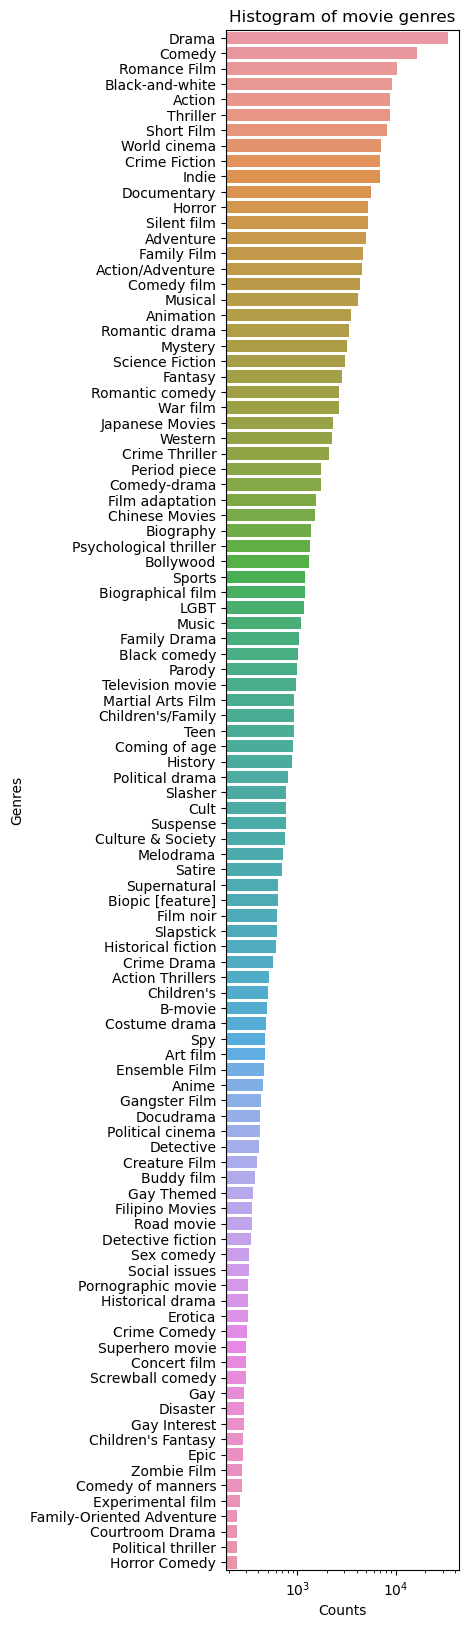

In [97]:
movie_genres_counts_filtered = movie_genres_counts[0:100]

plt.figure(figsize=(3, 20))
g = sns.barplot(y=movie_genres_counts_filtered.index, x=movie_genres_counts_filtered, orient='h')
g.set_xscale('log')
g.set_title('Histogram of movie genres')
g.set_xlabel('Counts')
g.set_ylabel('Genres')
plt.show()

# 2. Preprocessing and description of Oscar Award Dataset

In [12]:
oscar_winner = pd.read_csv('the_oscar_award.csv')
display(oscar_winner)

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10390,2019,2020,92,WRITING (Original Screenplay),"Screenplay by Bong Joon Ho, Han Jin Won; Story...",Parasite,True
10391,2019,2020,92,JEAN HERSHOLT HUMANITARIAN AWARD,Geena Davis,NaN,True
10392,2019,2020,92,HONORARY AWARD,David Lynch,NaN,True
10393,2019,2020,92,HONORARY AWARD,Wes Studi,NaN,True


In [24]:
oscar_nominated_actor = oscar_winner[oscar_winner['category'].str.contains('ACTOR') | oscar_winner['category'].str.contains('ACTRESS')].reset_index(drop=True)
# display(oscar_nominated_actor)

print('Total number of people nominated for Oscar:', len(oscar_nominated_actor['name'].unique()))

oscar_winning_actor = oscar_nominated_actor[oscar_nominated_actor['winner'] == True].reset_index(drop=True)
print('Total number of people nominated for Oscar:', len(oscar_winning_actor['name'].unique()))



Total number of people nominated for Oscar: 935
Total number of people nominated for Oscar: 305


In [25]:
oscar_winner_in_dataset = pd.merge(
    left=character_metadata,
    right=oscar_nominated_actor,
    left_on='Actor Name',
    right_on='name',
    how='inner'
)

display(oscar_winner_in_dataset)
# display(oscar_winner_in_dataset[oscar_winner_in_dataset['winner'] == True])

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor Name,Actor age at movie release,Freebase character map,No Idea 1,No Idea 2,year_film,year_ceremony,ceremony,category,name,film,winner
0,2238856,/m/06yc6v,2005-01,Richard Swersey,1959-09-11,M,1.78,NaN,John Hawkes,NaN,/m/0k0jnm,/m/0g98dqk,/m/0785v8,2010,2011,83,ACTOR IN A SUPPORTING ROLE,John Hawkes,Winter's Bone,False
1,2967115,/m/08gnl0,2001-09-10,Ticky Tobin,1959-09-11,M,1.78,NaN,John Hawkes,41.0,/m/0gc97xh,/m/0hp304z,/m/0785v8,2010,2011,83,ACTOR IN A SUPPORTING ROLE,John Hawkes,Winter's Bone,False
2,29007186,/m/0dgnwwr,2011-09-03,Roger,1959-09-11,M,1.78,NaN,John Hawkes,51.0,/m/0gvm_n5,/m/0h6jnwm,/m/0785v8,2010,2011,83,ACTOR IN A SUPPORTING ROLE,John Hawkes,Winter's Bone,False
3,8485294,/m/02753gr,2005,NaN,1959-09-11,M,1.78,NaN,John Hawkes,45.0,/m/0gc1h_c,NaN,/m/0785v8,2010,2011,83,ACTOR IN A SUPPORTING ROLE,John Hawkes,Winter's Bone,False
4,31514071,/m/0fpmrnk,2011-01-21,Patrick,1959-09-11,M,1.78,NaN,John Hawkes,51.0,/m/0gw6_l9,/m/0gw6_kd,/m/0785v8,2010,2011,83,ACTOR IN A SUPPORTING ROLE,John Hawkes,Winter's Bone,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71084,144778,/m/012c97,1931,NaN,1887-12-06,F,NaN,NaN,Lynn Fontanne,NaN,/m/0hzv_gy,NaN,/m/018436,1931,1932,5,ACTRESS,Lynn Fontanne,The Guardsman,False
71085,34331601,/m/0hzqm0n,1924-04-06,NaN,1887-12-06,F,NaN,NaN,Lynn Fontanne,NaN,/m/0mzt5nc,NaN,/m/018436,1931,1932,5,ACTRESS,Lynn Fontanne,The Guardsman,False
71086,5242523,/m/0d9mdg,1943-06-24,NaN,1887-12-06,F,NaN,NaN,Lynn Fontanne,NaN,/m/0gdl_km,NaN,/m/018436,1931,1932,5,ACTRESS,Lynn Fontanne,The Guardsman,False
71087,214324,/m/01fd9_,1965,Rozalie Lautmanova,1899-09-18,F,NaN,/m/041rx,Ida Kaminska,NaN,/m/0k6g2d,/m/02nwqm9,/m/01fd8r,1966,1967,39,ACTRESS,Ida Kaminska,The Shop on Main Street,False


In [18]:
print('Total number of actor data entry:', len(character_metadata))
print('Total number of actors:', len(character_metadata['Actor Name'].unique()))
print('')

Total number of actor data entry: 450669
Total number of actors: 134079
